# Feature Importance

In this file I use following methods to find out important features in data.

1. Perturbation : Adding noise in the feature checking how the model performance is deteriorated
2. Missing Values : Replacing feature values with 0 and checking how the model performance is deteriorated
3. Permutation : Shuffling the feature values and checking how the model performance is deteriorated
4. Shap Feature Importance: Using Shap's DeepExplainer to see time-step wise feature importance


### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Users/palig\MSE/Vertiefungsprojekt1/MSE_Vertierfungsprojekt1/data/raw/CMaps/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=False)
df_train.shape, df_test.shape, y_true.shape

C:\Users\palig\AppData\Local\Temp\ipykernel_39968\860272957.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
C:\Users\palig\AppData\Local\Temp\ipykernel_39968\860272957.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
C:\Users\palig\AppData\Local\Temp\ipykernel_39968\860272957.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


((20631, 27), (13096, 26), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-0.600784,-0.272028,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-0.674373,-0.177376,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-0.656414,-0.285110,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-0.650222,-0.666795,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-0.650532,-0.195845,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,0.292111,-0.558824,-0.735680,-0.382070,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,0.479744,-0.470588,-0.590463,-0.573682,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,0.398721,-0.558824,-0.688719,-0.082724,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,0.147122,-0.500000,-0.659820,-0.485956,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,0.475480,-0.558824,-0.694499,-0.398230,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = pd.concat([df_mask, id_df], ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 24)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 24)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

24

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

## Model 1

In [22]:
history = History()

model = Sequential()
model.add(LSTM(
         units=8,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 1056      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
# fit the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=64, 
                    validation_split=0.1, 
                    verbose=1, 
                    class_weight=cls_wt,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      min_delta=0, 
                                                      patience=10, 
                                                      verbose=1, 
                                                      mode='auto')
                    ])


Epoch 1/100
222/222 [==============================] - 3s 5ms/step - loss: 0.1763 - accuracy: 0.8592 - val_loss: 0.2730 - val_accuracy: 0.8926
Epoch 2/100
222/222 [==============================] - 1s 4ms/step - loss: 0.0876 - accuracy: 0.9294 - val_loss: 0.2110 - val_accuracy: 0.9295
Epoch 3/100
222/222 [==============================] - 1s 4ms/step - loss: 0.0658 - accuracy: 0.9450 - val_loss: 0.1483 - val_accuracy: 0.9479
Epoch 4/100
222/222 [==============================] - 1s 4ms/step - loss: 0.0564 - accuracy: 0.9479 - val_loss: 0.1372 - val_accuracy: 0.9536
Epoch 5/100
222/222 [==============================] - 1s 4ms/step - loss: 0.0518 - accuracy: 0.9516 - val_loss: 0.1190 - val_accuracy: 0.9473
Epoch 6/100
222/222 [==============================] - 1s 4ms/step - loss: 0.0472 - accuracy: 0.9553 - val_loss: 0.0867 - val_accuracy: 0.9720
Epoch 7/100
222/222 [==============================] - 1s 4ms/step - loss: 0.0451 - accuracy: 0.9569 - val_loss: 0.1665 - val_accuracy: 0.9346

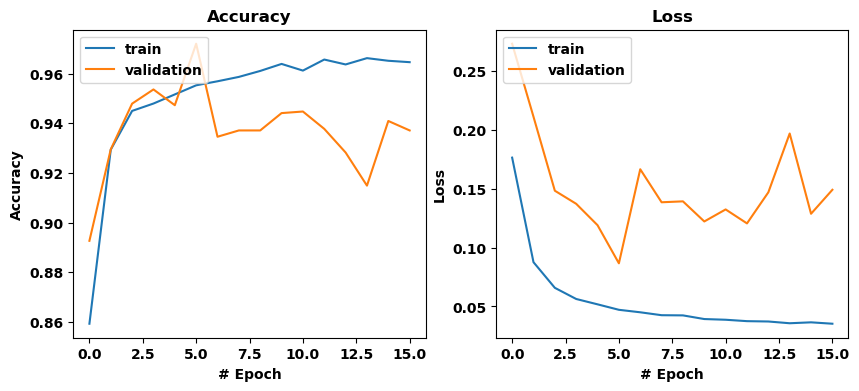

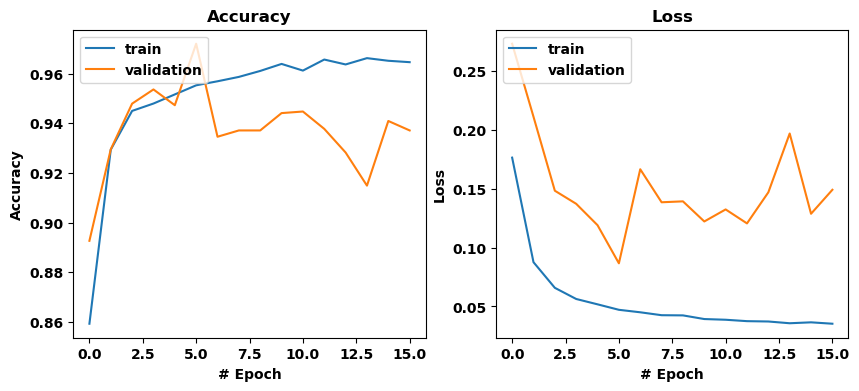

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

plt.show()

In [28]:
def print_results(y_test, y_pred):
    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

In [30]:


-*esults(y_true.failure, y_pred)

4/4 [==============================] - 0s 3ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [27]:
confusion_matrix(y_train, model.predict_classes(x_train))

array([[10350,   381],
       [  110,  4890]], dtype=int64)

In [28]:
train_probs = model.predict_proba(x_train)

### Perturbation 

In [29]:
y_true['failure_probability'] = model.predict_proba(x_test)
y_true.head()

,RUL,UnitNumber,failure,failure_probability
0,112,0,0,0.000598
1,98,1,0,0.001048
2,69,2,0,0.373701
3,82,3,0,0.008113
4,91,4,0,0.006418


In [30]:
feature_importance = pd.DataFrame(columns=["feature", "Importance"])

for i, feat in enumerate(feats):
    
    new_x = x_test.copy()
    
    np.random.seed(42)
    perturbation = np.random.normal(0.0, 1, size = new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model.predict_proba(new_x)
    
    effect = mean_squared_error(y_true.failure_probability, perturbed_out)
    feature_importance = feature_importance.append({"feature" : feat, "Importance" : effect}, ignore_index=True)

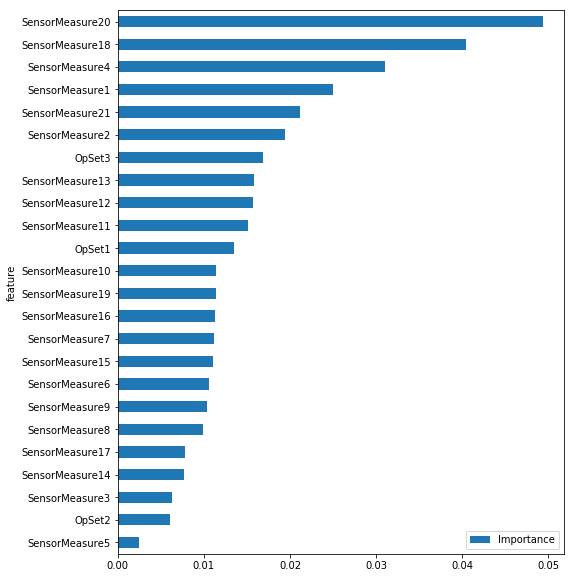

In [31]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance = feature_importance.sort_values(by = "Importance")
feature_importance.plot.barh(x = 'feature', y = 'Importance', ax = ax)

This is not right because OpSet3 is having on of the highest importance. Since we have only 8 nodes in hidden layer, network is not sparse and the weight of different features are shared. 

To remedy this, I would make sparse network with nodes in a hidden layer more than input features. This also helps for feature learning and to enrich feature represenatation.

## Model 2

In [32]:
len(feats)

24

In [54]:
history = History()

model2 = Sequential()
model2.add(LSTM(
         units=50,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [55]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14157 samples, validate on 1574 samples
Epoch 1/100


13696/14157 [============================>.] - ETA: 7:26 - loss: 0.3056 - acc: 0.312 - ETA: 3:50 - loss: 0.2974 - acc: 0.335 - ETA: 2:38 - loss: 0.2930 - acc: 0.515 - ETA: 2:01 - loss: 0.2811 - acc: 0.628 - ETA: 1:39 - loss: 0.2824 - acc: 0.659 - ETA: 1:24 - loss: 0.2790 - acc: 0.695 - ETA: 1:14 - loss: 0.2729 - acc: 0.727 - ETA: 1:06 - loss: 0.2678 - acc: 0.748 - ETA: 59s - loss: 0.2634 - acc: 0.765 - ETA: 54s - loss: 0.2581 - acc: 0.78 - ETA: 50s - loss: 0.2550 - acc: 0.79 - ETA: 47s - loss: 0.2509 - acc: 0.80 - ETA: 44s - loss: 0.2456 - acc: 0.81 - ETA: 42s - loss: 0.2418 - acc: 0.82 - ETA: 39s - loss: 0.2375 - acc: 0.82 - ETA: 37s - loss: 0.2341 - acc: 0.83 - ETA: 36s - loss: 0.2301 - acc: 0.83 - ETA: 34s - loss: 0.2261 - acc: 0.83 - ETA: 33s - loss: 0.2228 - acc: 0.83 - ETA: 32s - loss: 0.2205 - acc: 0.83 - ETA: 31s - loss: 0.2169 - acc: 0.83 - ETA: 30s - loss: 0.2134 - acc: 0.84 - ETA: 29s - loss: 0.2097 - acc: 0.84 - ETA: 28s - loss: 0.2057 - acc: 0.84 - ETA: 27s - loss: 0.2067 

14157/14157 [==============================] - ETA: 0s - loss: 0.0951 - acc: 0.918 - ETA: 0s - loss: 0.0950 - acc: 0.918 - ETA: 0s - loss: 0.0952 - acc: 0.918 - ETA: 0s - loss: 0.0951 - acc: 0.918 - ETA: 0s - loss: 0.0949 - acc: 0.918 - ETA: 0s - loss: 0.0946 - acc: 0.918 - ETA: 0s - loss: 0.0947 - acc: 0.918 - 17s 1ms/step - loss: 0.0947 - acc: 0.9185 - val_loss: 0.0934 - val_acc: 0.8920
Epoch 2/100


13760/14157 [============================>.] - ETA: 14s - loss: 0.0747 - acc: 0.87 - ETA: 16s - loss: 0.0628 - acc: 0.89 - ETA: 16s - loss: 0.0581 - acc: 0.92 - ETA: 16s - loss: 0.0518 - acc: 0.93 - ETA: 16s - loss: 0.0632 - acc: 0.92 - ETA: 16s - loss: 0.0608 - acc: 0.93 - ETA: 16s - loss: 0.0609 - acc: 0.93 - ETA: 15s - loss: 0.0596 - acc: 0.93 - ETA: 16s - loss: 0.0620 - acc: 0.93 - ETA: 16s - loss: 0.0622 - acc: 0.93 - ETA: 15s - loss: 0.0640 - acc: 0.93 - ETA: 15s - loss: 0.0640 - acc: 0.93 - ETA: 15s - loss: 0.0636 - acc: 0.93 - ETA: 15s - loss: 0.0626 - acc: 0.93 - ETA: 15s - loss: 0.0614 - acc: 0.94 - ETA: 15s - loss: 0.0656 - acc: 0.94 - ETA: 15s - loss: 0.0644 - acc: 0.94 - ETA: 15s - loss: 0.0625 - acc: 0.94 - ETA: 15s - loss: 0.0608 - acc: 0.94 - ETA: 15s - loss: 0.0620 - acc: 0.94 - ETA: 15s - loss: 0.0606 - acc: 0.94 - ETA: 14s - loss: 0.0622 - acc: 0.94 - ETA: 14s - loss: 0.0617 - acc: 0.94 - ETA: 14s - loss: 0.0627 - acc: 0.94 - ETA: 14s - loss: 0.0630 - acc: 0.94 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0586 - acc: 0.942 - ETA: 0s - loss: 0.0586 - acc: 0.942 - ETA: 0s - loss: 0.0585 - acc: 0.942 - ETA: 0s - loss: 0.0584 - acc: 0.942 - ETA: 0s - loss: 0.0583 - acc: 0.943 - ETA: 0s - loss: 0.0582 - acc: 0.943 - 15s 1ms/step - loss: 0.0581 - acc: 0.9431 - val_loss: 0.0495 - val_acc: 0.9504
Epoch 3/100


13760/14157 [============================>.] - ETA: 14s - loss: 0.0099 - acc: 1.00 - ETA: 16s - loss: 0.0346 - acc: 0.96 - ETA: 16s - loss: 0.0445 - acc: 0.94 - ETA: 16s - loss: 0.0671 - acc: 0.93 - ETA: 17s - loss: 0.0712 - acc: 0.93 - ETA: 16s - loss: 0.0673 - acc: 0.93 - ETA: 16s - loss: 0.0687 - acc: 0.93 - ETA: 16s - loss: 0.0644 - acc: 0.93 - ETA: 16s - loss: 0.0631 - acc: 0.93 - ETA: 15s - loss: 0.0600 - acc: 0.94 - ETA: 15s - loss: 0.0618 - acc: 0.93 - ETA: 15s - loss: 0.0606 - acc: 0.93 - ETA: 15s - loss: 0.0612 - acc: 0.93 - ETA: 15s - loss: 0.0618 - acc: 0.93 - ETA: 15s - loss: 0.0596 - acc: 0.93 - ETA: 15s - loss: 0.0608 - acc: 0.93 - ETA: 15s - loss: 0.0600 - acc: 0.93 - ETA: 14s - loss: 0.0596 - acc: 0.93 - ETA: 14s - loss: 0.0598 - acc: 0.93 - ETA: 14s - loss: 0.0593 - acc: 0.93 - ETA: 14s - loss: 0.0583 - acc: 0.93 - ETA: 14s - loss: 0.0571 - acc: 0.94 - ETA: 14s - loss: 0.0566 - acc: 0.94 - ETA: 14s - loss: 0.0573 - acc: 0.93 - ETA: 13s - loss: 0.0558 - acc: 0.94 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0506 - acc: 0.948 - ETA: 0s - loss: 0.0509 - acc: 0.948 - ETA: 0s - loss: 0.0509 - acc: 0.948 - ETA: 0s - loss: 0.0509 - acc: 0.948 - ETA: 0s - loss: 0.0507 - acc: 0.948 - ETA: 0s - loss: 0.0506 - acc: 0.949 - 15s 1ms/step - loss: 0.0506 - acc: 0.9491 - val_loss: 0.0646 - val_acc: 0.9161
Epoch 4/100


13760/14157 [============================>.] - ETA: 17s - loss: 0.0524 - acc: 0.93 - ETA: 15s - loss: 0.0578 - acc: 0.91 - ETA: 14s - loss: 0.0486 - acc: 0.93 - ETA: 15s - loss: 0.0522 - acc: 0.93 - ETA: 15s - loss: 0.0477 - acc: 0.94 - ETA: 15s - loss: 0.0491 - acc: 0.94 - ETA: 15s - loss: 0.0499 - acc: 0.94 - ETA: 15s - loss: 0.0510 - acc: 0.94 - ETA: 15s - loss: 0.0493 - acc: 0.94 - ETA: 15s - loss: 0.0472 - acc: 0.94 - ETA: 15s - loss: 0.0439 - acc: 0.95 - ETA: 15s - loss: 0.0474 - acc: 0.94 - ETA: 15s - loss: 0.0479 - acc: 0.94 - ETA: 14s - loss: 0.0489 - acc: 0.94 - ETA: 14s - loss: 0.0473 - acc: 0.94 - ETA: 14s - loss: 0.0450 - acc: 0.95 - ETA: 14s - loss: 0.0462 - acc: 0.94 - ETA: 14s - loss: 0.0471 - acc: 0.94 - ETA: 14s - loss: 0.0468 - acc: 0.95 - ETA: 14s - loss: 0.0461 - acc: 0.95 - ETA: 14s - loss: 0.0457 - acc: 0.95 - ETA: 13s - loss: 0.0471 - acc: 0.95 - ETA: 13s - loss: 0.0471 - acc: 0.95 - ETA: 13s - loss: 0.0466 - acc: 0.95 - ETA: 13s - loss: 0.0464 - acc: 0.95 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0469 - acc: 0.951 - ETA: 0s - loss: 0.0470 - acc: 0.951 - ETA: 0s - loss: 0.0469 - acc: 0.951 - ETA: 0s - loss: 0.0468 - acc: 0.951 - ETA: 0s - loss: 0.0470 - acc: 0.951 - ETA: 0s - loss: 0.0472 - acc: 0.951 - 15s 1ms/step - loss: 0.0471 - acc: 0.9513 - val_loss: 0.0505 - val_acc: 0.9422
Epoch 5/100


13760/14157 [============================>.] - ETA: 13s - loss: 0.0297 - acc: 0.95 - ETA: 14s - loss: 0.0359 - acc: 0.94 - ETA: 14s - loss: 0.0453 - acc: 0.93 - ETA: 15s - loss: 0.0405 - acc: 0.94 - ETA: 15s - loss: 0.0369 - acc: 0.95 - ETA: 14s - loss: 0.0353 - acc: 0.95 - ETA: 15s - loss: 0.0319 - acc: 0.95 - ETA: 15s - loss: 0.0327 - acc: 0.96 - ETA: 15s - loss: 0.0377 - acc: 0.95 - ETA: 14s - loss: 0.0377 - acc: 0.95 - ETA: 14s - loss: 0.0415 - acc: 0.95 - ETA: 14s - loss: 0.0451 - acc: 0.95 - ETA: 14s - loss: 0.0437 - acc: 0.95 - ETA: 14s - loss: 0.0445 - acc: 0.95 - ETA: 14s - loss: 0.0441 - acc: 0.95 - ETA: 14s - loss: 0.0440 - acc: 0.95 - ETA: 14s - loss: 0.0433 - acc: 0.95 - ETA: 13s - loss: 0.0436 - acc: 0.95 - ETA: 13s - loss: 0.0453 - acc: 0.94 - ETA: 13s - loss: 0.0452 - acc: 0.94 - ETA: 13s - loss: 0.0456 - acc: 0.94 - ETA: 13s - loss: 0.0452 - acc: 0.94 - ETA: 13s - loss: 0.0445 - acc: 0.95 - ETA: 13s - loss: 0.0454 - acc: 0.94 - ETA: 13s - loss: 0.0454 - acc: 0.94 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0431 - acc: 0.955 - ETA: 0s - loss: 0.0431 - acc: 0.955 - ETA: 0s - loss: 0.0432 - acc: 0.955 - ETA: 0s - loss: 0.0431 - acc: 0.955 - ETA: 0s - loss: 0.0430 - acc: 0.955 - ETA: 0s - loss: 0.0429 - acc: 0.955 - 15s 1ms/step - loss: 0.0429 - acc: 0.9555 - val_loss: 0.0428 - val_acc: 0.9492
Epoch 6/100


13760/14157 [============================>.] - ETA: 14s - loss: 0.0532 - acc: 0.95 - ETA: 15s - loss: 0.0331 - acc: 0.97 - ETA: 15s - loss: 0.0396 - acc: 0.96 - ETA: 16s - loss: 0.0441 - acc: 0.96 - ETA: 16s - loss: 0.0595 - acc: 0.95 - ETA: 15s - loss: 0.0539 - acc: 0.95 - ETA: 15s - loss: 0.0508 - acc: 0.95 - ETA: 15s - loss: 0.0541 - acc: 0.94 - ETA: 14s - loss: 0.0536 - acc: 0.94 - ETA: 14s - loss: 0.0535 - acc: 0.94 - ETA: 14s - loss: 0.0519 - acc: 0.94 - ETA: 14s - loss: 0.0506 - acc: 0.94 - ETA: 14s - loss: 0.0488 - acc: 0.94 - ETA: 15s - loss: 0.0478 - acc: 0.94 - ETA: 14s - loss: 0.0486 - acc: 0.94 - ETA: 15s - loss: 0.0477 - acc: 0.94 - ETA: 15s - loss: 0.0472 - acc: 0.95 - ETA: 15s - loss: 0.0478 - acc: 0.95 - ETA: 15s - loss: 0.0479 - acc: 0.95 - ETA: 15s - loss: 0.0475 - acc: 0.95 - ETA: 14s - loss: 0.0476 - acc: 0.95 - ETA: 14s - loss: 0.0465 - acc: 0.95 - ETA: 14s - loss: 0.0473 - acc: 0.94 - ETA: 14s - loss: 0.0471 - acc: 0.94 - ETA: 14s - loss: 0.0461 - acc: 0.95 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0404 - acc: 0.958 - ETA: 0s - loss: 0.0403 - acc: 0.959 - ETA: 0s - loss: 0.0402 - acc: 0.959 - ETA: 0s - loss: 0.0402 - acc: 0.959 - ETA: 0s - loss: 0.0402 - acc: 0.959 - ETA: 0s - loss: 0.0401 - acc: 0.959 - 15s 1ms/step - loss: 0.0402 - acc: 0.9592 - val_loss: 0.0847 - val_acc: 0.9104
Epoch 7/100


13760/14157 [============================>.] - ETA: 13s - loss: 0.0465 - acc: 0.95 - ETA: 13s - loss: 0.0587 - acc: 0.92 - ETA: 14s - loss: 0.0789 - acc: 0.91 - ETA: 14s - loss: 0.0879 - acc: 0.90 - ETA: 14s - loss: 0.0944 - acc: 0.89 - ETA: 15s - loss: 0.0962 - acc: 0.89 - ETA: 15s - loss: 0.0870 - acc: 0.90 - ETA: 14s - loss: 0.0789 - acc: 0.91 - ETA: 14s - loss: 0.0759 - acc: 0.92 - ETA: 14s - loss: 0.0766 - acc: 0.92 - ETA: 15s - loss: 0.0756 - acc: 0.92 - ETA: 15s - loss: 0.0726 - acc: 0.92 - ETA: 15s - loss: 0.0715 - acc: 0.92 - ETA: 15s - loss: 0.0703 - acc: 0.92 - ETA: 14s - loss: 0.0677 - acc: 0.93 - ETA: 14s - loss: 0.0668 - acc: 0.93 - ETA: 14s - loss: 0.0638 - acc: 0.93 - ETA: 14s - loss: 0.0623 - acc: 0.93 - ETA: 14s - loss: 0.0604 - acc: 0.93 - ETA: 14s - loss: 0.0601 - acc: 0.93 - ETA: 14s - loss: 0.0599 - acc: 0.93 - ETA: 14s - loss: 0.0581 - acc: 0.94 - ETA: 14s - loss: 0.0579 - acc: 0.94 - ETA: 13s - loss: 0.0574 - acc: 0.94 - ETA: 13s - loss: 0.0570 - acc: 0.94 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0417 - acc: 0.958 - ETA: 0s - loss: 0.0415 - acc: 0.959 - ETA: 0s - loss: 0.0414 - acc: 0.959 - ETA: 0s - loss: 0.0414 - acc: 0.958 - ETA: 0s - loss: 0.0414 - acc: 0.959 - ETA: 0s - loss: 0.0414 - acc: 0.959 - 16s 1ms/step - loss: 0.0414 - acc: 0.9591 - val_loss: 0.0381 - val_acc: 0.9581
Epoch 8/100


13760/14157 [============================>.] - ETA: 13s - loss: 0.0417 - acc: 0.96 - ETA: 13s - loss: 0.0365 - acc: 0.96 - ETA: 14s - loss: 0.0256 - acc: 0.97 - ETA: 15s - loss: 0.0239 - acc: 0.98 - ETA: 15s - loss: 0.0217 - acc: 0.97 - ETA: 15s - loss: 0.0250 - acc: 0.97 - ETA: 15s - loss: 0.0245 - acc: 0.97 - ETA: 15s - loss: 0.0225 - acc: 0.97 - ETA: 14s - loss: 0.0339 - acc: 0.97 - ETA: 14s - loss: 0.0337 - acc: 0.97 - ETA: 14s - loss: 0.0346 - acc: 0.97 - ETA: 14s - loss: 0.0353 - acc: 0.96 - ETA: 14s - loss: 0.0352 - acc: 0.96 - ETA: 14s - loss: 0.0375 - acc: 0.96 - ETA: 14s - loss: 0.0390 - acc: 0.96 - ETA: 14s - loss: 0.0379 - acc: 0.96 - ETA: 14s - loss: 0.0384 - acc: 0.96 - ETA: 14s - loss: 0.0376 - acc: 0.96 - ETA: 14s - loss: 0.0360 - acc: 0.96 - ETA: 14s - loss: 0.0392 - acc: 0.96 - ETA: 14s - loss: 0.0411 - acc: 0.95 - ETA: 13s - loss: 0.0420 - acc: 0.95 - ETA: 13s - loss: 0.0426 - acc: 0.95 - ETA: 13s - loss: 0.0415 - acc: 0.95 - ETA: 13s - loss: 0.0414 - acc: 0.95 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0365 - acc: 0.963 - ETA: 0s - loss: 0.0366 - acc: 0.963 - ETA: 0s - loss: 0.0366 - acc: 0.963 - ETA: 0s - loss: 0.0367 - acc: 0.963 - ETA: 0s - loss: 0.0368 - acc: 0.963 - ETA: 0s - loss: 0.0368 - acc: 0.963 - 15s 1ms/step - loss: 0.0368 - acc: 0.9632 - val_loss: 0.0500 - val_acc: 0.9365
Epoch 9/100


13760/14157 [============================>.] - ETA: 12s - loss: 0.0347 - acc: 0.95 - ETA: 14s - loss: 0.0287 - acc: 0.96 - ETA: 14s - loss: 0.0237 - acc: 0.97 - ETA: 15s - loss: 0.0283 - acc: 0.96 - ETA: 14s - loss: 0.0374 - acc: 0.95 - ETA: 14s - loss: 0.0357 - acc: 0.95 - ETA: 15s - loss: 0.0329 - acc: 0.96 - ETA: 15s - loss: 0.0366 - acc: 0.95 - ETA: 14s - loss: 0.0362 - acc: 0.95 - ETA: 15s - loss: 0.0342 - acc: 0.96 - ETA: 14s - loss: 0.0350 - acc: 0.96 - ETA: 14s - loss: 0.0343 - acc: 0.96 - ETA: 14s - loss: 0.0344 - acc: 0.96 - ETA: 14s - loss: 0.0334 - acc: 0.96 - ETA: 14s - loss: 0.0322 - acc: 0.96 - ETA: 14s - loss: 0.0318 - acc: 0.96 - ETA: 14s - loss: 0.0308 - acc: 0.97 - ETA: 14s - loss: 0.0300 - acc: 0.97 - ETA: 14s - loss: 0.0310 - acc: 0.97 - ETA: 14s - loss: 0.0321 - acc: 0.96 - ETA: 14s - loss: 0.0339 - acc: 0.96 - ETA: 14s - loss: 0.0355 - acc: 0.96 - ETA: 14s - loss: 0.0361 - acc: 0.96 - ETA: 14s - loss: 0.0351 - acc: 0.96 - ETA: 14s - loss: 0.0342 - acc: 0.96 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0353 - acc: 0.964 - ETA: 0s - loss: 0.0353 - acc: 0.964 - ETA: 0s - loss: 0.0352 - acc: 0.964 - ETA: 0s - loss: 0.0353 - acc: 0.964 - ETA: 0s - loss: 0.0354 - acc: 0.964 - ETA: 0s - loss: 0.0354 - acc: 0.964 - 15s 1ms/step - loss: 0.0354 - acc: 0.9641 - val_loss: 0.0464 - val_acc: 0.9435
Epoch 10/100


13760/14157 [============================>.] - ETA: 15s - loss: 0.0134 - acc: 0.98 - ETA: 16s - loss: 0.0253 - acc: 0.97 - ETA: 16s - loss: 0.0294 - acc: 0.97 - ETA: 15s - loss: 0.0313 - acc: 0.97 - ETA: 15s - loss: 0.0297 - acc: 0.97 - ETA: 15s - loss: 0.0301 - acc: 0.97 - ETA: 14s - loss: 0.0347 - acc: 0.97 - ETA: 14s - loss: 0.0361 - acc: 0.97 - ETA: 14s - loss: 0.0361 - acc: 0.96 - ETA: 14s - loss: 0.0353 - acc: 0.96 - ETA: 14s - loss: 0.0343 - acc: 0.96 - ETA: 14s - loss: 0.0339 - acc: 0.96 - ETA: 14s - loss: 0.0335 - acc: 0.96 - ETA: 14s - loss: 0.0333 - acc: 0.96 - ETA: 14s - loss: 0.0319 - acc: 0.96 - ETA: 14s - loss: 0.0310 - acc: 0.97 - ETA: 14s - loss: 0.0323 - acc: 0.96 - ETA: 14s - loss: 0.0317 - acc: 0.96 - ETA: 14s - loss: 0.0317 - acc: 0.96 - ETA: 14s - loss: 0.0308 - acc: 0.96 - ETA: 14s - loss: 0.0328 - acc: 0.96 - ETA: 14s - loss: 0.0343 - acc: 0.96 - ETA: 14s - loss: 0.0359 - acc: 0.96 - ETA: 13s - loss: 0.0361 - acc: 0.96 - ETA: 13s - loss: 0.0360 - acc: 0.96 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0339 - acc: 0.966 - ETA: 0s - loss: 0.0340 - acc: 0.966 - ETA: 0s - loss: 0.0340 - acc: 0.966 - ETA: 0s - loss: 0.0339 - acc: 0.966 - ETA: 0s - loss: 0.0341 - acc: 0.966 - ETA: 0s - loss: 0.0341 - acc: 0.966 - 15s 1ms/step - loss: 0.0341 - acc: 0.9664 - val_loss: 0.0636 - val_acc: 0.9295
Epoch 11/100


13760/14157 [============================>.] - ETA: 11s - loss: 0.0637 - acc: 0.95 - ETA: 13s - loss: 0.0508 - acc: 0.95 - ETA: 13s - loss: 0.0376 - acc: 0.96 - ETA: 13s - loss: 0.0343 - acc: 0.96 - ETA: 13s - loss: 0.0317 - acc: 0.96 - ETA: 13s - loss: 0.0303 - acc: 0.96 - ETA: 13s - loss: 0.0303 - acc: 0.96 - ETA: 13s - loss: 0.0366 - acc: 0.96 - ETA: 13s - loss: 0.0379 - acc: 0.96 - ETA: 13s - loss: 0.0364 - acc: 0.96 - ETA: 13s - loss: 0.0366 - acc: 0.96 - ETA: 13s - loss: 0.0366 - acc: 0.96 - ETA: 13s - loss: 0.0350 - acc: 0.96 - ETA: 13s - loss: 0.0346 - acc: 0.96 - ETA: 13s - loss: 0.0346 - acc: 0.96 - ETA: 13s - loss: 0.0342 - acc: 0.96 - ETA: 13s - loss: 0.0338 - acc: 0.96 - ETA: 13s - loss: 0.0331 - acc: 0.96 - ETA: 13s - loss: 0.0331 - acc: 0.96 - ETA: 13s - loss: 0.0322 - acc: 0.96 - ETA: 13s - loss: 0.0320 - acc: 0.96 - ETA: 13s - loss: 0.0316 - acc: 0.96 - ETA: 13s - loss: 0.0308 - acc: 0.96 - ETA: 13s - loss: 0.0306 - acc: 0.97 - ETA: 13s - loss: 0.0305 - acc: 0.97 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0318 - acc: 0.968 - ETA: 0s - loss: 0.0318 - acc: 0.968 - ETA: 0s - loss: 0.0318 - acc: 0.968 - ETA: 0s - loss: 0.0317 - acc: 0.968 - ETA: 0s - loss: 0.0317 - acc: 0.968 - ETA: 0s - loss: 0.0318 - acc: 0.968 - 15s 1ms/step - loss: 0.0317 - acc: 0.9681 - val_loss: 0.0427 - val_acc: 0.9416
Epoch 12/100


13760/14157 [============================>.] - ETA: 13s - loss: 0.0199 - acc: 0.98 - ETA: 13s - loss: 0.0253 - acc: 0.96 - ETA: 13s - loss: 0.0294 - acc: 0.96 - ETA: 13s - loss: 0.0405 - acc: 0.95 - ETA: 13s - loss: 0.0337 - acc: 0.96 - ETA: 13s - loss: 0.0371 - acc: 0.95 - ETA: 13s - loss: 0.0342 - acc: 0.96 - ETA: 13s - loss: 0.0321 - acc: 0.96 - ETA: 13s - loss: 0.0295 - acc: 0.96 - ETA: 13s - loss: 0.0319 - acc: 0.96 - ETA: 13s - loss: 0.0311 - acc: 0.96 - ETA: 13s - loss: 0.0306 - acc: 0.96 - ETA: 13s - loss: 0.0301 - acc: 0.96 - ETA: 13s - loss: 0.0294 - acc: 0.96 - ETA: 13s - loss: 0.0291 - acc: 0.97 - ETA: 13s - loss: 0.0293 - acc: 0.97 - ETA: 13s - loss: 0.0286 - acc: 0.97 - ETA: 12s - loss: 0.0278 - acc: 0.97 - ETA: 12s - loss: 0.0280 - acc: 0.97 - ETA: 12s - loss: 0.0277 - acc: 0.97 - ETA: 12s - loss: 0.0282 - acc: 0.97 - ETA: 12s - loss: 0.0290 - acc: 0.97 - ETA: 12s - loss: 0.0292 - acc: 0.97 - ETA: 12s - loss: 0.0296 - acc: 0.97 - ETA: 12s - loss: 0.0295 - acc: 0.97 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0314 - acc: 0.969 - ETA: 0s - loss: 0.0314 - acc: 0.969 - ETA: 0s - loss: 0.0314 - acc: 0.969 - ETA: 0s - loss: 0.0315 - acc: 0.969 - ETA: 0s - loss: 0.0314 - acc: 0.969 - ETA: 0s - loss: 0.0313 - acc: 0.969 - 14s 1ms/step - loss: 0.0313 - acc: 0.9696 - val_loss: 0.0668 - val_acc: 0.9301
Epoch 13/100


13760/14157 [============================>.] - ETA: 12s - loss: 0.0194 - acc: 0.96 - ETA: 14s - loss: 0.0381 - acc: 0.94 - ETA: 13s - loss: 0.0364 - acc: 0.94 - ETA: 13s - loss: 0.0490 - acc: 0.93 - ETA: 13s - loss: 0.0426 - acc: 0.94 - ETA: 13s - loss: 0.0374 - acc: 0.95 - ETA: 13s - loss: 0.0368 - acc: 0.95 - ETA: 13s - loss: 0.0349 - acc: 0.95 - ETA: 13s - loss: 0.0350 - acc: 0.95 - ETA: 13s - loss: 0.0330 - acc: 0.96 - ETA: 13s - loss: 0.0321 - acc: 0.96 - ETA: 13s - loss: 0.0329 - acc: 0.96 - ETA: 13s - loss: 0.0327 - acc: 0.96 - ETA: 13s - loss: 0.0329 - acc: 0.96 - ETA: 13s - loss: 0.0355 - acc: 0.96 - ETA: 13s - loss: 0.0342 - acc: 0.96 - ETA: 13s - loss: 0.0348 - acc: 0.96 - ETA: 13s - loss: 0.0379 - acc: 0.95 - ETA: 13s - loss: 0.0396 - acc: 0.95 - ETA: 13s - loss: 0.0385 - acc: 0.95 - ETA: 13s - loss: 0.0385 - acc: 0.95 - ETA: 13s - loss: 0.0388 - acc: 0.95 - ETA: 12s - loss: 0.0447 - acc: 0.95 - ETA: 12s - loss: 0.0442 - acc: 0.95 - ETA: 12s - loss: 0.0429 - acc: 0.95 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0318 - acc: 0.970 - ETA: 0s - loss: 0.0318 - acc: 0.970 - ETA: 0s - loss: 0.0318 - acc: 0.970 - ETA: 0s - loss: 0.0319 - acc: 0.970 - ETA: 0s - loss: 0.0318 - acc: 0.970 - ETA: 0s - loss: 0.0320 - acc: 0.970 - 15s 1ms/step - loss: 0.0319 - acc: 0.9700 - val_loss: 0.0484 - val_acc: 0.9377
Epoch 14/100


13760/14157 [============================>.] - ETA: 16s - loss: 0.0467 - acc: 0.93 - ETA: 17s - loss: 0.0329 - acc: 0.95 - ETA: 17s - loss: 0.0294 - acc: 0.96 - ETA: 18s - loss: 0.0403 - acc: 0.96 - ETA: 17s - loss: 0.0358 - acc: 0.96 - ETA: 17s - loss: 0.0362 - acc: 0.96 - ETA: 17s - loss: 0.0393 - acc: 0.95 - ETA: 16s - loss: 0.0398 - acc: 0.95 - ETA: 16s - loss: 0.0370 - acc: 0.95 - ETA: 16s - loss: 0.0361 - acc: 0.95 - ETA: 16s - loss: 0.0337 - acc: 0.96 - ETA: 15s - loss: 0.0326 - acc: 0.96 - ETA: 15s - loss: 0.0313 - acc: 0.96 - ETA: 15s - loss: 0.0310 - acc: 0.96 - ETA: 15s - loss: 0.0313 - acc: 0.96 - ETA: 15s - loss: 0.0320 - acc: 0.96 - ETA: 15s - loss: 0.0308 - acc: 0.96 - ETA: 15s - loss: 0.0298 - acc: 0.96 - ETA: 15s - loss: 0.0300 - acc: 0.96 - ETA: 14s - loss: 0.0313 - acc: 0.96 - ETA: 14s - loss: 0.0317 - acc: 0.96 - ETA: 14s - loss: 0.0314 - acc: 0.96 - ETA: 14s - loss: 0.0319 - acc: 0.96 - ETA: 14s - loss: 0.0309 - acc: 0.96 - ETA: 14s - loss: 0.0299 - acc: 0.96 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0294 - acc: 0.969 - ETA: 0s - loss: 0.0295 - acc: 0.969 - ETA: 0s - loss: 0.0295 - acc: 0.969 - ETA: 0s - loss: 0.0296 - acc: 0.969 - ETA: 0s - loss: 0.0297 - acc: 0.969 - ETA: 0s - loss: 0.0297 - acc: 0.969 - 16s 1ms/step - loss: 0.0297 - acc: 0.9692 - val_loss: 0.0420 - val_acc: 0.9517
Epoch 15/100


13760/14157 [============================>.] - ETA: 14s - loss: 0.0191 - acc: 0.98 - ETA: 15s - loss: 0.0281 - acc: 0.96 - ETA: 16s - loss: 0.0350 - acc: 0.95 - ETA: 16s - loss: 0.0536 - acc: 0.94 - ETA: 15s - loss: 0.0581 - acc: 0.92 - ETA: 15s - loss: 0.0615 - acc: 0.92 - ETA: 14s - loss: 0.0635 - acc: 0.92 - ETA: 14s - loss: 0.0613 - acc: 0.93 - ETA: 14s - loss: 0.0577 - acc: 0.93 - ETA: 14s - loss: 0.0553 - acc: 0.93 - ETA: 14s - loss: 0.0545 - acc: 0.93 - ETA: 14s - loss: 0.0560 - acc: 0.94 - ETA: 14s - loss: 0.0542 - acc: 0.94 - ETA: 14s - loss: 0.0521 - acc: 0.94 - ETA: 14s - loss: 0.0525 - acc: 0.94 - ETA: 14s - loss: 0.0545 - acc: 0.94 - ETA: 14s - loss: 0.0527 - acc: 0.94 - ETA: 13s - loss: 0.0522 - acc: 0.94 - ETA: 13s - loss: 0.0499 - acc: 0.95 - ETA: 13s - loss: 0.0491 - acc: 0.95 - ETA: 13s - loss: 0.0481 - acc: 0.95 - ETA: 13s - loss: 0.0475 - acc: 0.95 - ETA: 13s - loss: 0.0489 - acc: 0.95 - ETA: 13s - loss: 0.0491 - acc: 0.95 - ETA: 13s - loss: 0.0488 - acc: 0.95 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0321 - acc: 0.968 - ETA: 0s - loss: 0.0320 - acc: 0.968 - ETA: 0s - loss: 0.0321 - acc: 0.968 - ETA: 0s - loss: 0.0321 - acc: 0.968 - ETA: 0s - loss: 0.0321 - acc: 0.968 - ETA: 0s - loss: 0.0321 - acc: 0.968 - 16s 1ms/step - loss: 0.0321 - acc: 0.9682 - val_loss: 0.0535 - val_acc: 0.9384
Epoch 16/100


13760/14157 [============================>.] - ETA: 16s - loss: 0.0210 - acc: 0.96 - ETA: 16s - loss: 0.0230 - acc: 0.97 - ETA: 16s - loss: 0.0194 - acc: 0.97 - ETA: 16s - loss: 0.0185 - acc: 0.98 - ETA: 15s - loss: 0.0239 - acc: 0.97 - ETA: 15s - loss: 0.0249 - acc: 0.96 - ETA: 15s - loss: 0.0251 - acc: 0.96 - ETA: 15s - loss: 0.0242 - acc: 0.96 - ETA: 15s - loss: 0.0245 - acc: 0.96 - ETA: 15s - loss: 0.0233 - acc: 0.96 - ETA: 15s - loss: 0.0240 - acc: 0.97 - ETA: 14s - loss: 0.0264 - acc: 0.96 - ETA: 14s - loss: 0.0263 - acc: 0.96 - ETA: 14s - loss: 0.0269 - acc: 0.96 - ETA: 14s - loss: 0.0258 - acc: 0.96 - ETA: 14s - loss: 0.0258 - acc: 0.96 - ETA: 14s - loss: 0.0264 - acc: 0.96 - ETA: 14s - loss: 0.0258 - acc: 0.96 - ETA: 14s - loss: 0.0252 - acc: 0.97 - ETA: 14s - loss: 0.0253 - acc: 0.97 - ETA: 13s - loss: 0.0251 - acc: 0.97 - ETA: 13s - loss: 0.0248 - acc: 0.97 - ETA: 13s - loss: 0.0242 - acc: 0.97 - ETA: 13s - loss: 0.0251 - acc: 0.97 - ETA: 13s - loss: 0.0245 - acc: 0.97 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0271 - acc: 0.971 - ETA: 0s - loss: 0.0272 - acc: 0.971 - ETA: 0s - loss: 0.0271 - acc: 0.972 - ETA: 0s - loss: 0.0272 - acc: 0.972 - ETA: 0s - loss: 0.0272 - acc: 0.971 - ETA: 0s - loss: 0.0274 - acc: 0.971 - 15s 1ms/step - loss: 0.0273 - acc: 0.9717 - val_loss: 0.0646 - val_acc: 0.9460
Epoch 17/100


13760/14157 [============================>.] - ETA: 12s - loss: 0.0198 - acc: 0.96 - ETA: 12s - loss: 0.0515 - acc: 0.94 - ETA: 13s - loss: 0.0491 - acc: 0.94 - ETA: 13s - loss: 0.0405 - acc: 0.95 - ETA: 13s - loss: 0.0378 - acc: 0.96 - ETA: 13s - loss: 0.0350 - acc: 0.96 - ETA: 13s - loss: 0.0350 - acc: 0.96 - ETA: 13s - loss: 0.0330 - acc: 0.96 - ETA: 13s - loss: 0.0302 - acc: 0.97 - ETA: 13s - loss: 0.0290 - acc: 0.97 - ETA: 13s - loss: 0.0294 - acc: 0.97 - ETA: 13s - loss: 0.0299 - acc: 0.97 - ETA: 13s - loss: 0.0305 - acc: 0.96 - ETA: 13s - loss: 0.0307 - acc: 0.96 - ETA: 13s - loss: 0.0314 - acc: 0.96 - ETA: 13s - loss: 0.0311 - acc: 0.96 - ETA: 12s - loss: 0.0300 - acc: 0.96 - ETA: 12s - loss: 0.0288 - acc: 0.97 - ETA: 12s - loss: 0.0294 - acc: 0.97 - ETA: 12s - loss: 0.0293 - acc: 0.97 - ETA: 12s - loss: 0.0290 - acc: 0.97 - ETA: 12s - loss: 0.0290 - acc: 0.97 - ETA: 12s - loss: 0.0292 - acc: 0.97 - ETA: 12s - loss: 0.0288 - acc: 0.97 - ETA: 12s - loss: 0.0293 - acc: 0.97 - ETA

14157/14157 [==============================] - ETA: 0s - loss: 0.0276 - acc: 0.973 - ETA: 0s - loss: 0.0276 - acc: 0.973 - ETA: 0s - loss: 0.0276 - acc: 0.973 - ETA: 0s - loss: 0.0277 - acc: 0.973 - ETA: 0s - loss: 0.0276 - acc: 0.973 - ETA: 0s - loss: 0.0276 - acc: 0.973 - 21s 1ms/step - loss: 0.0276 - acc: 0.9737 - val_loss: 0.0477 - val_acc: 0.9511
Wall time: 4min 28s


Text(0.5, 1.0, 'Loss')

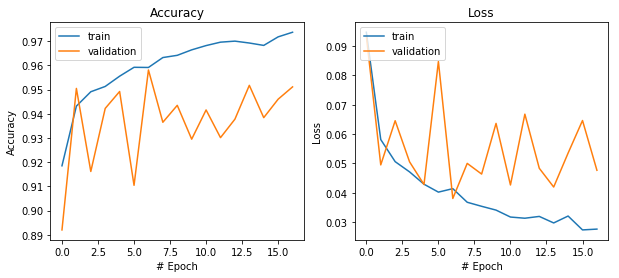

In [56]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.94      1.00      0.97        30

    accuracy                           0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Area under curve :  0.9857142857142857 



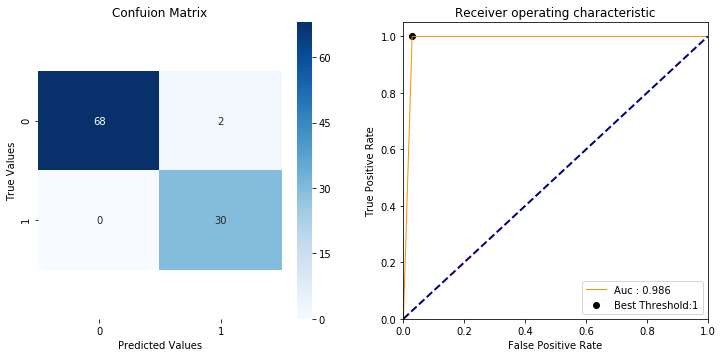

In [57]:
y_pred = model2.predict_classes(x_test)

print_results(y_true.failure, y_pred)

In [58]:
confusion_matrix(y_train, model2.predict_classes(x_train))

array([[10488,   243],
       [  237,  4763]], dtype=int64)

In [59]:
test_probs2 = model2.predict_proba(x_test)

### Perturbation 

In [103]:
feature_importance2 = pd.DataFrame(columns=["feature", "Importance"])

for i, feat in enumerate(feats):
    
    new_x = x_test.copy()
    
    np.random.seed(42)
    perturbation = np.random.normal(0.0, 1, size = new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model2.predict_proba(new_x)
    
    effect = mean_squared_error(test_probs2, perturbed_out)
    feature_importance2 = feature_importance2.append({"feature" : feat, "Importance" : effect}, ignore_index=True)

Text(0.5, 1.0, 'Perturbation: Feature Importance')

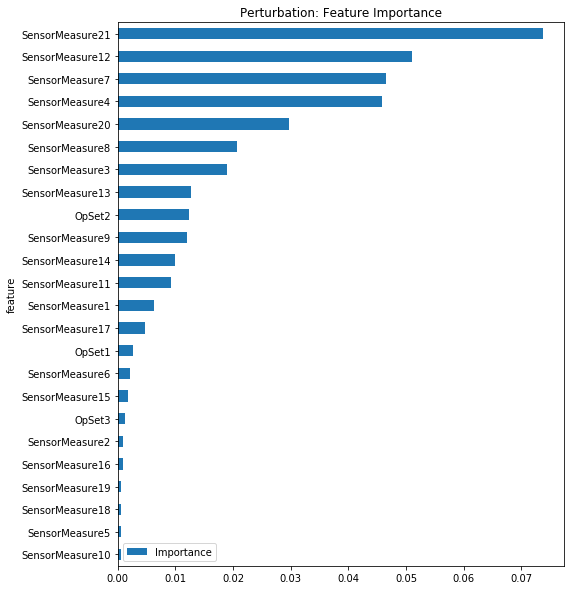

In [104]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2 = feature_importance2.sort_values(by = "Importance")
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)
ax.set_title('Perturbation: Feature Importance')

### Missing Values 

In [101]:
feature_importance2 = pd.DataFrame(columns=["feature", "Importance"])

for i, feat in enumerate(feats):
    
    new_x = x_test.copy()
    
    new_x[:, :, i] = 0
    missing_probs = model2.predict_proba(new_x)
    
    effect = mean_squared_error(test_probs2, missing_probs)
    feature_importance2 = feature_importance2.append({"feature" : feat, "Importance" : effect}, ignore_index=True)

Text(0.5, 1.0, 'Missing Values: Feature Importance')

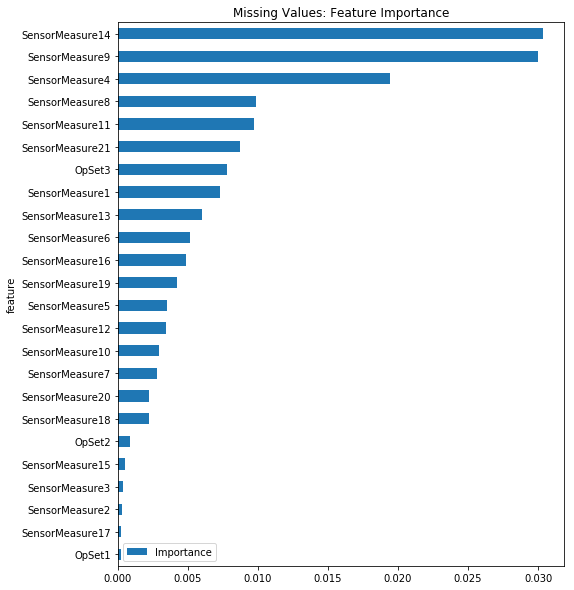

In [102]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2 = feature_importance2.sort_values(by = "Importance")
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)
ax.set_title('Missing Values: Feature Importance')

### Permutation 

In [99]:
feature_importance2 = pd.DataFrame(columns=["feature", "Importance"])

for i, feat in enumerate(feats):
    
    new_x = x_test.copy()
    
    np.random.shuffle(new_x[:, :, i])
    permute_probs = model2.predict_proba(new_x)
    
    effect = mean_squared_error(test_probs2, permute_probs)
    feature_importance2 = feature_importance2.append({"feature" : feat, "Importance" : effect}, ignore_index=True)

Text(0.5, 1.0, 'Permutation: Feature Importance')

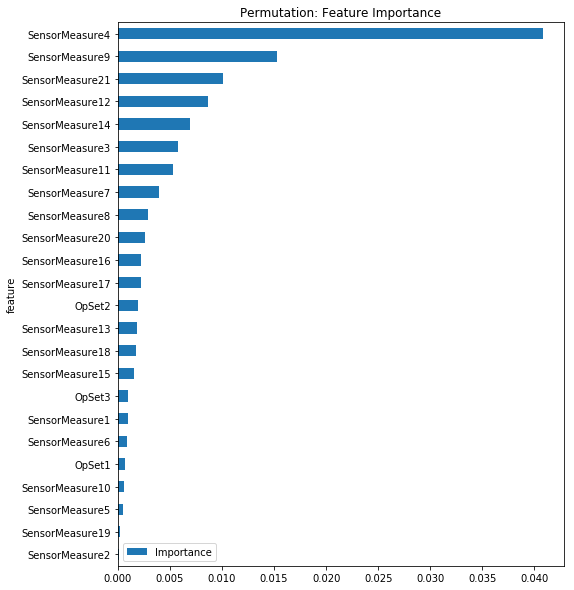

In [100]:
fig, ax = plt.subplots(figsize = (8,10))
feature_importance2 = feature_importance2.sort_values(by = "Importance")
feature_importance2.plot.barh(x = 'feature', y = 'Importance', ax = ax)
ax.set_title('Permutation: Feature Importance')

### Shap Values 

In [69]:
import shap

random_ind = np.random.choice(x_train.shape[0], 1000, replace = False)
data = x_train[random_ind[0:1000]]

DE = shap.DeepExplainer(model2, data)
shap_val = DE.shap_values(x_test)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val, (shap_val.shape[1], shap_val.shape[2], shap_val.shape[3]))
shap_abs = np.abs(shap_val)
sum_0 = np.sum(shap_abs, axis = 0)

print(sum_0.shape)

(50, 24)


#### Last day's important features

Text(0.5, 1.0, 'Shap Feature Importance of last cycle')

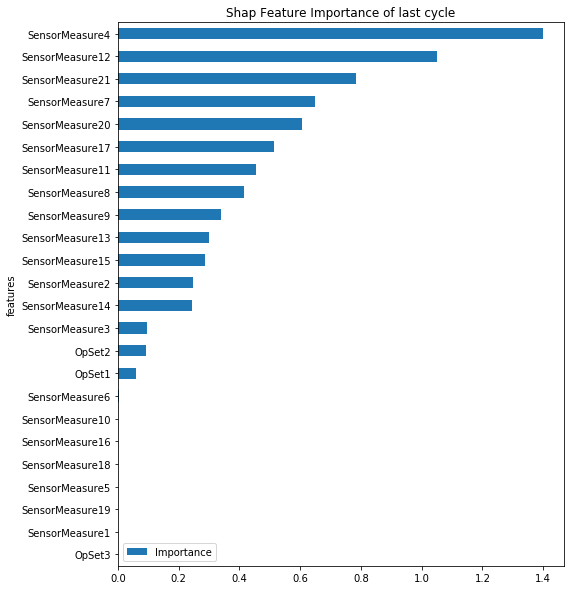

In [85]:
shap_feat_importance = pd.DataFrame(columns=["features", "Importance"])
shap_feat_importance.features = feats
shap_feat_importance.Importance = sum_0[49]

fig, ax = plt.subplots(figsize = (8,10))
shap_feat_importance = shap_feat_importance.sort_values(by = "Importance")
shap_feat_importance.plot.barh(x = 'features', y = 'Importance', ax = ax)
ax.set_title('Shap Feature Importance of last cycle')

#### First day's important features

Text(0.5, 1.0, 'Shap Feature Importance of first cycle')

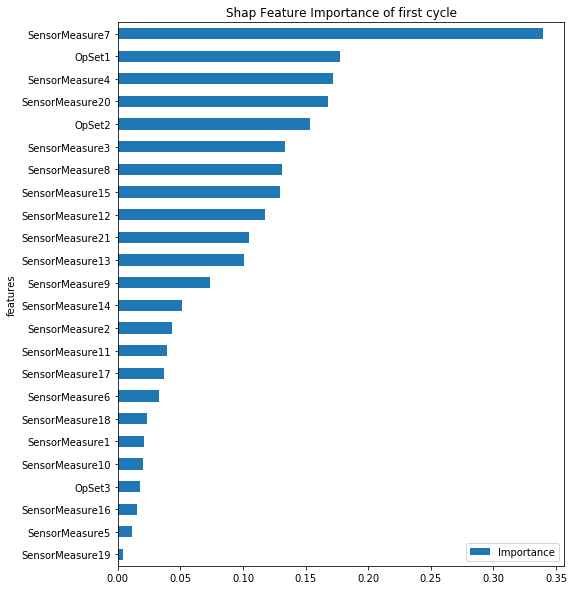

In [86]:
shap_feat_importance = pd.DataFrame(columns=["features", "Importance"])
shap_feat_importance.features = feats
shap_feat_importance.Importance = sum_0[0]

fig, ax = plt.subplots(figsize = (8,10))
shap_feat_importance = shap_feat_importance.sort_values(by = "Importance")
shap_feat_importance.plot.barh(x = 'features', y = 'Importance', ax = ax)
ax.set_title('Shap Feature Importance of first cycle')

#### Over all feature importance

Text(0.5, 1.0, 'Shap Feature Importance')

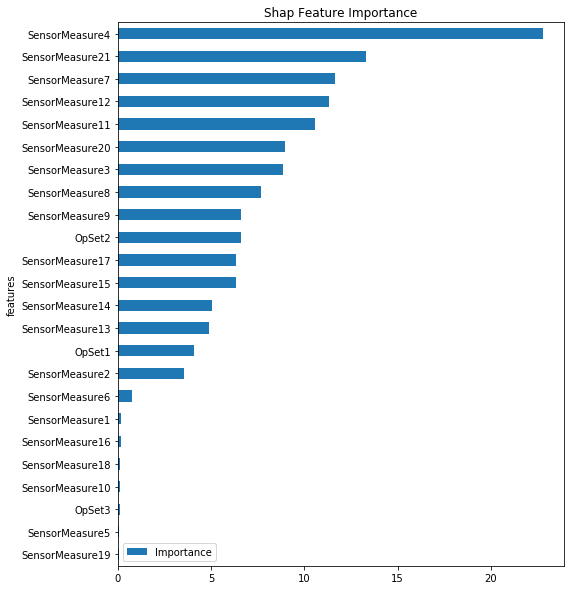

In [83]:
shap_feat_importance = pd.DataFrame(columns=["features", "Importance"])
shap_feat_importance.features = feats
shap_feat_importance.Importance = sum_0.sum(axis = 0)

fig, ax = plt.subplots(figsize = (8,10))
shap_feat_importance = shap_feat_importance.sort_values(by = "Importance")
shap_feat_importance.plot.barh(x = 'features', y = 'Importance', ax = ax)
ax.set_title('Shap Feature Importance')

### Feature Importance Visualization over time steps

In [90]:
feat_imp_df = pd.DataFrame(sum_0, columns=feats)
feat_imp_df.head()

,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,0.177128,0.153225,0.017702,0.020642,0.043494,0.133174,0.171820,0.011259,0.033200,0.339510,...,0.117782,0.100679,0.051401,0.129179,0.015316,0.036476,0.023623,0.004098,0.168036,0.104745
1,0.170273,0.088665,0.014327,0.020354,0.036693,0.148077,0.154789,0.008803,0.026685,0.229829,...,0.070765,0.099017,0.054793,0.132376,0.014042,0.034819,0.018682,0.002637,0.106628,0.068968
2,0.112825,0.055524,0.013298,0.020747,0.027213,0.158710,0.176549,0.007364,0.023955,0.265730,...,0.061481,0.084197,0.059605,0.159666,0.013694,0.035956,0.015727,0.001511,0.092378,0.065964
3,0.104163,0.055922,0.012496,0.020455,0.020965,0.153333,0.223608,0.005855,0.028843,0.165332,...,0.049015,0.074528,0.069548,0.147011,0.012782,0.045271,0.013496,0.000761,0.072804,0.099781
4,0.078619,0.059778,0.007774,0.008041,0.016626,0.151519,0.211282,0.003982,0.009674,0.145528,...,0.052937,0.063619,0.068165,0.114973,0.002798,0.054150,0.009466,0.000765,0.061762,0.129174


#### Operational Setting

Text(0, 0.5, 'Feature Importance')

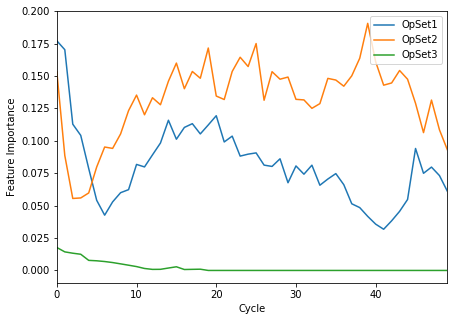

In [97]:
fig, ax = plt.subplots(figsize = (7,5))
feat_imp_df[["OpSet1", "OpSet2", "OpSet3"]].plot(ax = ax)
ax.set_xlabel("Cycle")
ax.set_ylabel("Feature Importance")

#### Top 5 Sensor Measures

Text(0, 0.5, 'Feature Importance')

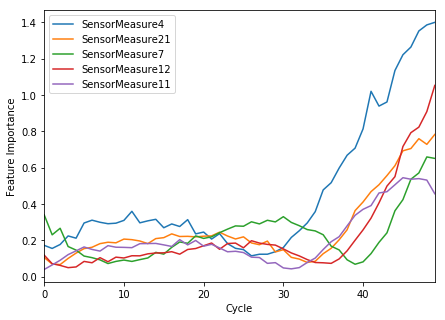

In [98]:
fig, ax = plt.subplots(figsize = (7,5))
feat_imp_df[["SensorMeasure4", "SensorMeasure21", "SensorMeasure7", "SensorMeasure12", "SensorMeasure11"]].plot(ax = ax)
ax.set_xlabel("Cycle")
ax.set_ylabel("Feature Importance")